# drug-gym

Imports.

In [1]:
%load_ext autoreload
%autoreload 2

import dgym as dg
from useful_rdkit_utils import rd_shut_the_hell_up
rd_shut_the_hell_up()

Load data.

In [2]:
from dgym import collection, repertoire

# load all data
print('load data')
path = '../dgym-data'

deck = collection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

repertoire = repertoire.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.env.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fps = dg.env.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fps = dg.env.utils.sort_fingerprints(fps, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.env.utils.get_unique_reactants(repertoire)
building_blocks = dg.env.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

load data
align fingerprints
partition building blocks


In [123]:
from dgllife.utils import (
    smiles_to_bigraph,
    CanonicalAtomFeaturizer,
)
from dgllife.model import load_pretrained


In [4]:
import os
from dgym.env.datasets import DGLLifeUnlabeledDataset

def get_oracles(properties = []):
    oracles = {}
    for prop in properties:
        model = load_pretrained(prop, log=False)
        model = model.eval()
        oracles[prop] = model
    return oracles

oracles = get_oracles(properties=['GCN_canonical_Lipophilicity'])

def get_properties(collection, properties = ['GCN_canonical_Lipophilicity']):

    def _make_dataset(collection):
        return DGLLifeUnlabeledDataset(
            collection,
            mol_to_graph=dgllife.utils.MolToBigraph(
                add_self_loop=True,
                node_featurizer=CanonicalAtomFeaturizer(),
            )
        )

    # TODO - make actual loop over properties
    for prop in properties:
        dataset = _make_dataset(collection)
        graph_batch = dgl.batch(dataset.graphs)
        feats_batch = graph_batch.ndata['h']

        oracle = oracles[prop]
        preds = oracle(graph_batch, feats_batch).flatten().tolist()

    return preds

In [12]:
import gymnasium as gym

class DrugEnv(gym.Env):
    """Environment for Drug Discovery
    
    Class that implements a gym.Env interface for drug discovery.
    See https://gymnasium.farama.org/ for details on gymnasium.
    
    """
    def __init__(
        self,
        budget: int = 100,
    ) -> None:

        # of molecules
        self.budget = budget

        # spaces - TODO
        self.action_space = NotImplemented
        self.observation_space = NotImplemented
        self.oracles = get_oracles(properties=['GCN_canonical_Lipophilicity'])
        
        # episode
        self._done = None
        self._history = None
        self._total_reward = None
        self._total_costs = None
        self._first_rendering = None

    def reset(self):
        self._done = False
        self.history = {}
    
    def step(self, orders):
        results = []
        failed_orders = []
        for service, molecules in orders:
            try:
                result = get_properties(molecules, [service])
                assert len(result) == len(molecules)
                results.append((service, molecules, result))
            except:
                failed_orders.append((service, molecules))
        return results, failed_orders

In [125]:
drug_agent = DrugAgent(
    repertoire=repertoire,
    building_blocks=building_blocks
)

In [126]:
service = 'GCN_canonical_ESOL'
# get_properties(molecules, [service])

In [171]:
deck_lipo = get_properties(deck, ['GCN_canonical_Lipophilicity'])
k = 20
top_k = np.argsort(deck_lipo)[-k:]
hits = collection.Collection([
    deck[int(k_i)] for k_i in top_k
])

In [172]:
from tqdm.notebook import tqdm

# hits = deck[50:60]

analogs = []
for hit in tqdm(hits):
    analogs.extend(drug_agent._enumerate(hit, sortby='random', k=5))

len(analogs)

  0%|          | 0/20 [00:00<?, ?it/s]

77

  0%|          | 0/9 [00:00<?, ?it/s]

round 1


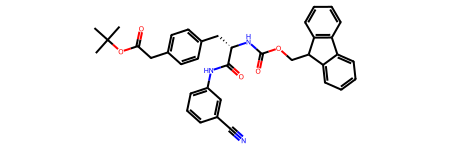

round 2


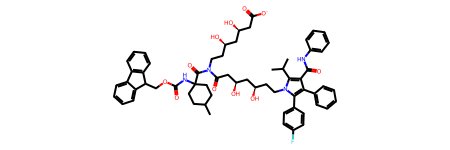

round 3


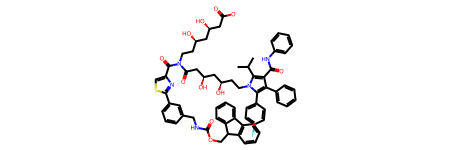

round 4
Processing molecule 1000/999


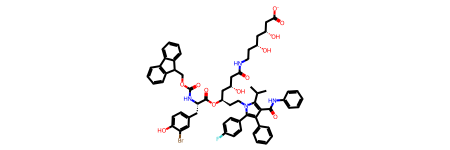

round 5
Processing molecule 1000/999


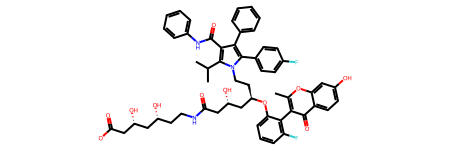

round 6
Processing molecule 1000/999


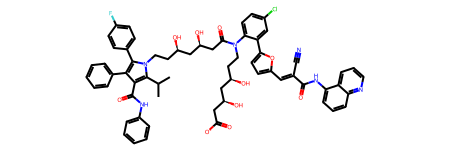

round 7
Processing molecule 1000/999
Processing molecule 2000/1999


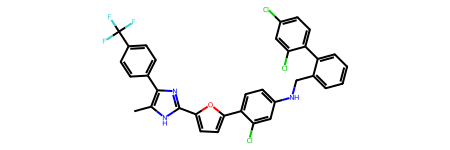

round 8
Processing molecule 1000/999
Processing molecule 2000/1999


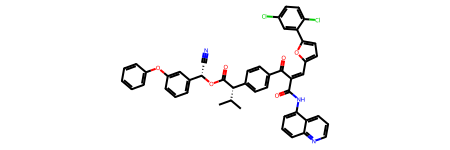

round 9
Processing molecule 1000/999
Processing molecule 2000/1999


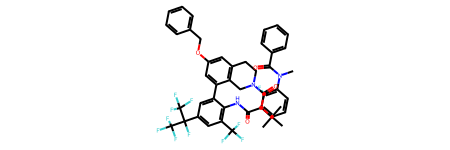

In [173]:
import tqdm.notebook as tq

drug_agent = DrugAgent(
    repertoire=repertoire,
    building_blocks=building_blocks
)
drug_env = DrugEnv(budget=1000)

# hits = deck[300:320] # [200:220]

history = []
history.extend([
    {'round': 0,
     'mol_index': idx,
     'logD': m}
    for idx, m in enumerate(drug_agent._featurize(hits.molecules))
])

for i in tq.tqdm(range(1, 10)):
    
    print('round', i)
    orders = drug_agent.step(
        hits,
        properties=['GCN_canonical_Lipophilicity'],
        sortby='random',
        k=20
    )
    results, failed_orders = drug_env.step([orders])
    assay, molecules, measurements = results[0]
    hits = collection.Collection([
        mol for _, mol
        in sorted(zip(measurements, molecules),
                  key=lambda x: x[0], reverse=True)
    ])
    
    history.extend([
        {'round': i,
         'mol_index': idx,
         'logD': m}
        for idx, m in enumerate(measurements)
    ])

    display(hits[0])

Text(0.5, 1.0, 'Lipophilicity | sortby = random | k = 50')

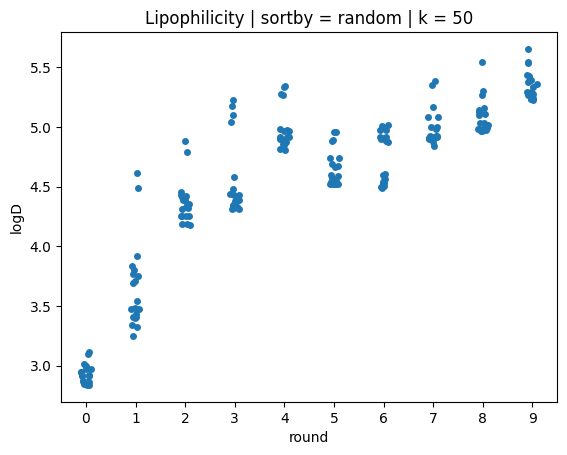

In [175]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(
    data=pd.DataFrame(history),
    x='round',
    y='logD',
)

plt.title('Lipophilicity | sortby = random | k = 50')

Text(0.5, 1.0, 'Lipophilicity | sortby = diversity | k = 50')

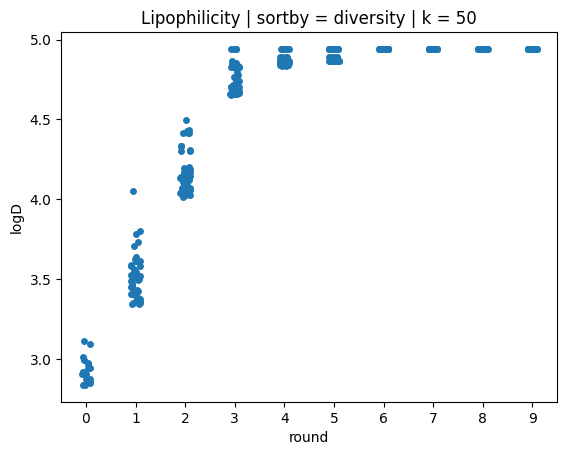

In [169]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.stripplot(
    data=pd.DataFrame(history),
    x='round',
    y='logD',
)

plt.title('Lipophilicity | sortby = diversity | k = 50')